# 

# Assignment 2

## Imports

In [174]:
# part one and two 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

## part two
import torch
import torch.nn as nn

## Functions

In [175]:
class TwoLayerMLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.tanh(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        exp_scores = np.exp(self.Z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    
    def compute_loss(self, y, probs):
        correct_logprobs = -np.log(probs[range(len(y)), y])
        data_loss = np.sum(correct_logprobs)
        return 1./len(y) * data_loss
    
    def backprop(self, X, y, probs, learning_rate=0.01):
        delta3 = probs
        delta3[range(len(y)), y] -= 1
        dW2 = (self.A1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * (1 - np.power(self.A1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Gradient descent parameter update
        self.W1 += -learning_rate * dW1
        self.b1 += -learning_rate * db1
        self.W2 += -learning_rate * dW2
        self.b2 += -learning_rate * db2
    
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def fit(self, X, y, epochs=2000, learning_rate=0.01):
        for i in range(epochs):
            probs = self.forward(X)
            loss = self.compute_loss(y, probs)
            self.backprop(X, y, probs)
            if i % 1000 == 0:
                print("Loss after iteration %i: %f" %(i, loss))

In [176]:
# Step 2: Define the model architecture with variable number of layers
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        layers = []
        for i, hidden_dim in enumerate(hidden_dims):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dim))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dim))
            layers.append(nn.ReLU())  # You can try other activation functions here
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [177]:
# Training function
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs=1000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [178]:
# Evaluation function
def evaluate_model(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
        print(f'Accuracy: {accuracy:.2f}')

        cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
        print('Confusion Matrix:')
        print(cm)

## First Part

### Data preparation

In [179]:
df = pd.read_csv('multiclass_data.csv')
df.drop(columns=df.columns[0], inplace=True) 
X = df.drop(columns=['labels']).values
y = df['labels'].values

# NN implementation
# Training and test split utilizing 8:2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model parameters
input_size = X_train_scaled.shape[1]
hidden_size = 5
output_size = len(np.unique(y))
epochs = 1000
learning_rate = 0.01

# Initialize and train the model
model = TwoLayerMLP(input_size, hidden_size, output_size)
model.fit(X_train_scaled, y_train, epochs, learning_rate)

Loss after iteration 0: 1.386177


In [180]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Trained Model Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Trained Model Accuracy: 1.0
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


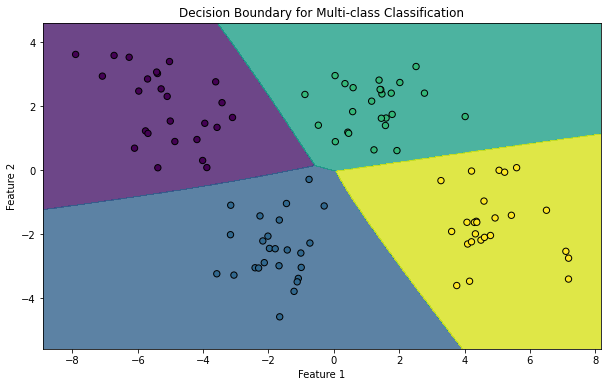

In [181]:
# Setup the meshgrid for the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the function value for the whole grid
Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Decision Boundary for Multi-class Classification")
plt.show()

## Part 2

In [182]:
# Load the data
df = pd.read_csv('multiclass_data.csv')
X = df[['feature1', 'feature2']].values
y = df['labels'].values

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Experimenting with different model configs
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
hidden_dims_list = [[32], [64], [32, 32], [64, 64], [32, 32, 32], [32, 32, 64], [32, 64, 32], [64, 64, 64]]


Training model with hidden dimensions: [32]
Epoch [100/1000], Loss: 0.9317
Epoch [200/1000], Loss: 0.6596
Epoch [300/1000], Loss: 0.4819
Epoch [400/1000], Loss: 0.3647
Epoch [500/1000], Loss: 0.2861
Epoch [600/1000], Loss: 0.2323
Epoch [700/1000], Loss: 0.1940
Epoch [800/1000], Loss: 0.1657
Epoch [900/1000], Loss: 0.1442
Epoch [1000/1000], Loss: 0.1274

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


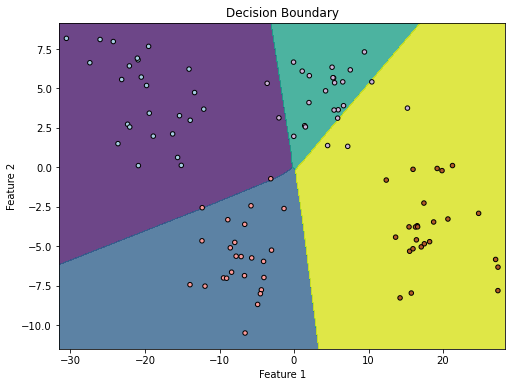


Training model with hidden dimensions: [64]
Epoch [100/1000], Loss: 0.6040
Epoch [200/1000], Loss: 0.3741
Epoch [300/1000], Loss: 0.2681
Epoch [400/1000], Loss: 0.2087
Epoch [500/1000], Loss: 0.1709
Epoch [600/1000], Loss: 0.1449
Epoch [700/1000], Loss: 0.1258
Epoch [800/1000], Loss: 0.1113
Epoch [900/1000], Loss: 0.0998
Epoch [1000/1000], Loss: 0.0905

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


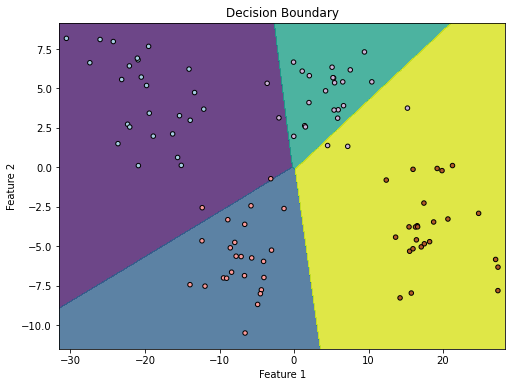


Training model with hidden dimensions: [32, 32]
Epoch [100/1000], Loss: 1.0896
Epoch [200/1000], Loss: 0.8073
Epoch [300/1000], Loss: 0.6001
Epoch [400/1000], Loss: 0.4480
Epoch [500/1000], Loss: 0.3330
Epoch [600/1000], Loss: 0.2449
Epoch [700/1000], Loss: 0.1805
Epoch [800/1000], Loss: 0.1358
Epoch [900/1000], Loss: 0.1054
Epoch [1000/1000], Loss: 0.0845

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


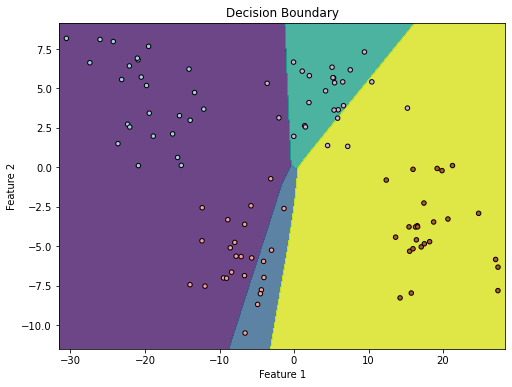


Training model with hidden dimensions: [64, 64]
Epoch [100/1000], Loss: 0.8369
Epoch [200/1000], Loss: 0.5205
Epoch [300/1000], Loss: 0.3148
Epoch [400/1000], Loss: 0.2001
Epoch [500/1000], Loss: 0.1390
Epoch [600/1000], Loss: 0.1040
Epoch [700/1000], Loss: 0.0822
Epoch [800/1000], Loss: 0.0675
Epoch [900/1000], Loss: 0.0570
Epoch [1000/1000], Loss: 0.0492

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


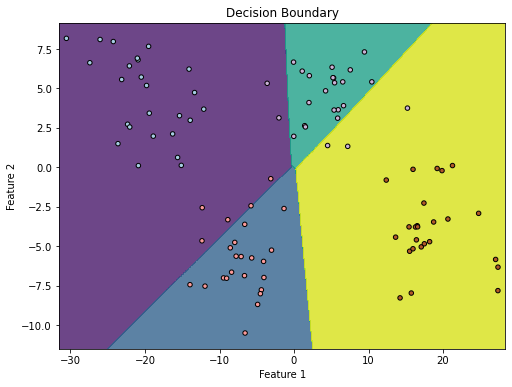


Training model with hidden dimensions: [32, 32, 32]
Epoch [100/1000], Loss: 1.3550
Epoch [200/1000], Loss: 1.2994
Epoch [300/1000], Loss: 1.1917
Epoch [400/1000], Loss: 0.9953
Epoch [500/1000], Loss: 0.7433
Epoch [600/1000], Loss: 0.5191
Epoch [700/1000], Loss: 0.3618
Epoch [800/1000], Loss: 0.2499
Epoch [900/1000], Loss: 0.1718
Epoch [1000/1000], Loss: 0.1211

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


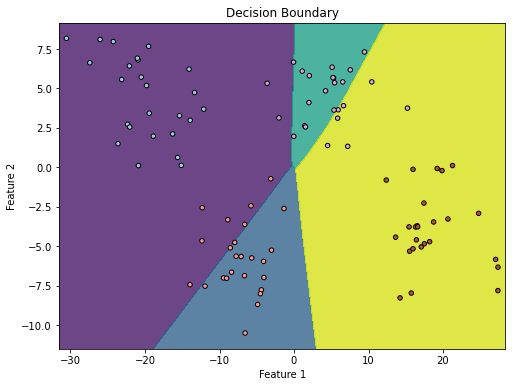


Training model with hidden dimensions: [32, 32, 64]
Epoch [100/1000], Loss: 1.3111
Epoch [200/1000], Loss: 1.2031
Epoch [300/1000], Loss: 0.9990
Epoch [400/1000], Loss: 0.7058
Epoch [500/1000], Loss: 0.4284
Epoch [600/1000], Loss: 0.2465
Epoch [700/1000], Loss: 0.1522
Epoch [800/1000], Loss: 0.1040
Epoch [900/1000], Loss: 0.0767
Epoch [1000/1000], Loss: 0.0597

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


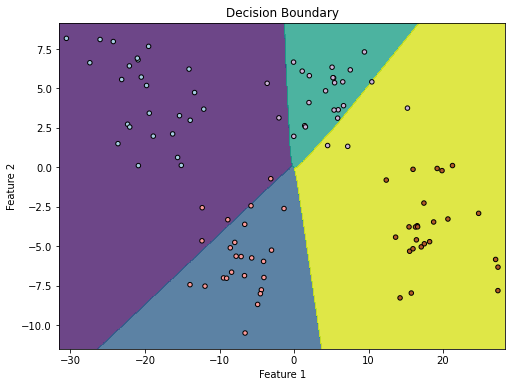


Training model with hidden dimensions: [32, 64, 32]
Epoch [100/1000], Loss: 1.2963
Epoch [200/1000], Loss: 1.1520
Epoch [300/1000], Loss: 0.9126
Epoch [400/1000], Loss: 0.6482
Epoch [500/1000], Loss: 0.4087
Epoch [600/1000], Loss: 0.2389
Epoch [700/1000], Loss: 0.1480
Epoch [800/1000], Loss: 0.1014
Epoch [900/1000], Loss: 0.0750
Epoch [1000/1000], Loss: 0.0587

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


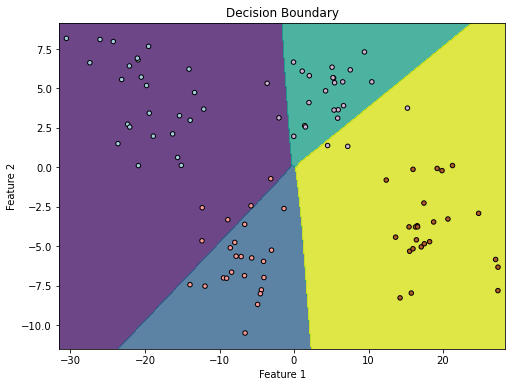


Training model with hidden dimensions: [64, 64, 64]
Epoch [100/1000], Loss: 1.2943
Epoch [200/1000], Loss: 1.1124
Epoch [300/1000], Loss: 0.8175
Epoch [400/1000], Loss: 0.5268
Epoch [500/1000], Loss: 0.2899
Epoch [600/1000], Loss: 0.1623
Epoch [700/1000], Loss: 0.1036
Epoch [800/1000], Loss: 0.0736
Epoch [900/1000], Loss: 0.0560
Epoch [1000/1000], Loss: 0.0448

Evaluating model performance:
Accuracy: 1.00
Confusion Matrix:
[[4 0 0 0]
 [0 6 0 0]
 [0 0 5 0]
 [0 0 0 5]]


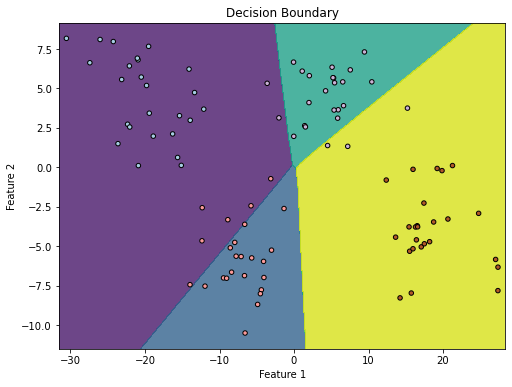

In [186]:
# Experimentation with different model configs
def plot_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Forward pass to get model predictions
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).argmax(dim=1)
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=20)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

for hidden_dims in hidden_dims_list:
    model = MLP(input_dim=X_train.shape[1], hidden_dims=hidden_dims, output_dim=len(np.unique(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    print(f"\nTraining model with hidden dimensions: {hidden_dims}")
    train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor)
    print("\nEvaluating model performance:")
    evaluate_model(model, X_test_tensor, y_test_tensor)
    # Plot decision boundary for each model
    plot_decision_boundary(model, scaler.inverse_transform(X), y)  # Using original, unscaled features for plotting

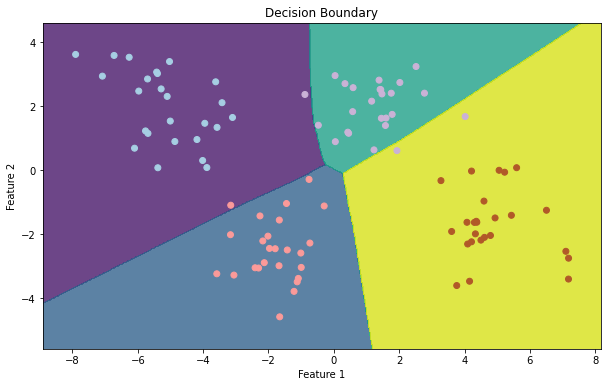

In [184]:
# Plot decision boundary for the last trained model
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).argmax(dim=1)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()